In [ ]:
from copy import deepcopy
import numpy as np
import bifrost as bf
import bifrost.blocks as blocks
import bifrost.views as views
import bifrost.pipeline as bfp
from bifrost.ndarray import copy_array
import pylab as plt

class CopyBlock(bfp.TransformBlock):#
    """Copy the input ring to output ring"""
    def __init__(self, iring, space=None, *args, **kwargs):
        super(CopyBlock, self).__init__(iring, *args, **kwargs)
        if space is None:
            space = self.iring.space
        self.orings = [self.create_ring(space=space)]
    def on_sequence(self, iseq):
        ohdr = deepcopy(iseq.header)
        return ohdr
    def on_data(self, ispan, ospan):
        copy_array(ospan.data, ispan.data)#

raw_data = blocks.read_wav(['Trial2.wav'], gulp_nframe=4096)

gpu_raw_data = CopyBlock(raw_data, space='cuda')#
chunked_data = views.split_axis(gpu_raw_data, 'time', 256, label='fine_time')
fft_output = blocks.fft(chunked_data, axes='fine_time', axis_labels='freq')
squared = blocks.detect(fft_output, mode='scalar')
transposed = blocks.transpose(squared, ['time', 'pol', 'freq'])#

host_transposed = blocks.copy(transposed, space='cuda_host')
quantized = blocks.quantize(host_transposed, 'i8')
blocks.write_sigproc(quantized)

pipeline = bf.get_default_pipeline()#
pipeline.shutdown_on_signals()
pipeline.run()#

In [ ]:
help(blocks.detect)

Help on function detect in module bifrost.blocks.detect:

detect(iring, mode, axis=None, *args, **kwargs)
    Apply square-law detection to create polarization products.
    Args:
        iring (Ring or Block): Input data source.
        mode (string):
           ``'scalar': x   -> real x.x*``
           ``'jones':  x,y -> complex x.x* + 1j*y.y*, x.y*``
           ``'stokes': x,y -> real I, Q, U, V``
           ``'stokes_I': x,y -> x.x* + y.y* (Stokes I)``
        axis: Integer or string specifying the polarization axis. Defaults to
                'pol'. Not used if mode = 'scalar'.
        *args: Arguments to ``bifrost.pipeline.TransformBlock``.
        **kwargs: Keyword Arguments to ``bifrost.pipeline.TransformBlock``.
    **Tensor semantics**::
        Input:  [..., 'pol', ...], dtype = any complex, space = CUDA
        Output: [..., 'pol', ...], dtype = real or complex, space = CUDA
    Returns:
        DetectBlock: A new block instance.



In [ ]:
from blimpy import waterfall

In [10]:
import blimpy as bl

fp='Trial2.wav.fil'
fil = bl.Waterfall(fp)
fil.data = fil.data[:, 0:1, :]

In [ ]:
%matplotlib inline

/home/cho134/.local/lib/python3.9/site-packages/blimpy/utils.py:11: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(x + offset)


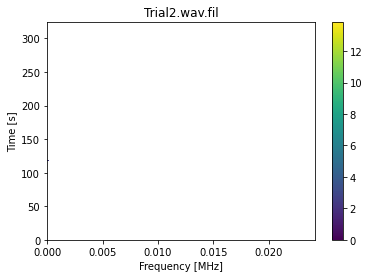

In [ ]:
fil.plot_waterfall()

/tmp/ipykernel_5141/3831591803.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.array(fil.data).squeeze()), aspect='auto')


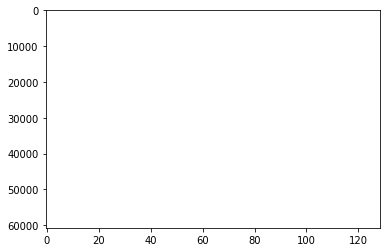

In [11]:
plt.imshow(np.log(np.array(fil.data).squeeze()), aspect='auto')